# Task description
- Classify the speakers of given features.
- Main goal: Learn how to use transformer.
- Baselines:
  - Easy: Run sample code and know how to use transformer.
  - Medium: Know how to adjust parameters of transformer.
  - Hard: Construct [conformer](https://arxiv.org/abs/2005.08100) which is a variety of transformer.

- Other links
  - Kaggle: [link](https://www.kaggle.com/t/859c9ca9ede14fdea841be627c412322)
  - Slide: [link](https://speech.ee.ntu.edu.tw/~hylee/ml/ml2021-course-data/hw/HW04/HW04.pdf)
  - Data: [link](https://drive.google.com/file/d/1T0RPnu-Sg5eIPwQPfYysipfcz81MnsYe/view?usp=sharing)
  - Video (Chinese): [link](https://www.youtube.com/watch?v=EPerg2UnGaI)
  - Video (English): [link](https://www.youtube.com/watch?v=Gpz6AUvCak0)
  - Solution for downloading dataset fail.: [link](https://drive.google.com/drive/folders/13T0Pa_WGgQxNkqZk781qhc5T9-zfh19e?usp=sharing)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import shutil
shutil.copyfile('/content/drive/MyDrive/Colab Notebooks/Dataset.zip','/content/Dataset.zip')

import zipfile
with zipfile.ZipFile('/content/Dataset.zip','r') as zip_ref:
  zip_ref.extractall('/content/')

Mounted at /content/drive


# Download dataset
- Please follow [here](https://drive.google.com/drive/folders/13T0Pa_WGgQxNkqZk781qhc5T9-zfh19e?usp=sharing) to download data
- Data is [here](https://drive.google.com/file/d/1gaFy8RaQVUEXo2n0peCBR5gYKCB-mNHc/view?usp=sharing)

In [ ]:
!gdown --id 'https://drive.google.com/file/d/1gaFy8RaQVUEXo2n0peCBR5gYKCB-mNHc/view' --output Dataset.zip
!unzip Dataset.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=https://drive.google.com/file/d/1gaFy8RaQVUEXo2n0peCBR5gYKCB-mNHc/view 

unzip:  cannot find or open Dataset.zip, Dataset.zip.zip or Dataset.zip.ZIP.


# Data

## Dataset
- Original dataset is [Voxceleb1](https://www.robots.ox.ac.uk/~vgg/data/voxceleb/).
- The [license](https://creativecommons.org/licenses/by/4.0/) and [complete version](https://www.robots.ox.ac.uk/~vgg/data/voxceleb/files/license.txt) of Voxceleb1.
- We randomly select 600 speakers from Voxceleb1.
- Then preprocess the raw waveforms into mel-spectrograms.

- Args:
  - data_dir: The path to the data directory.
  - metadata_path: The path to the metadata.
  - segment_len: The length of audio segment for training.
- The architecture of data directory \\
  - data directory \\
  |---- metadata.json \\
  |---- testdata.json \\
  |---- mapping.json \\
  |---- uttr-{random string}.pt \\

- The information in metadata
  - "n_mels": The dimention of mel-spectrogram.
  - "speakers": A dictionary.
    - Key: speaker ids.
    - value: "feature_path" and "mel_len"


For efficiency, we segment the mel-spectrograms into segments in the traing step.

In [1]:
import os
import json
import torch
import random
from pathlib import Path
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence


class myDataset(Dataset):
  def __init__(self, data_dir, segment_len=128):
    self.data_dir = data_dir
    self.segment_len = segment_len

    # Load the mapping from speaker neme to their corresponding id.
    mapping_path = Path(data_dir) / "mapping.json"
    mapping = json.load(mapping_path.open())
    self.speaker2id = mapping["speaker2id"]

    # Load metadata of training data.
    metadata_path = Path(data_dir) / "metadata.json"
    metadata = json.load(open(metadata_path))["speakers"]

    # Get the total number of speaker.
    self.speaker_num = len(metadata.keys())
    self.data = []
    for speaker in metadata.keys():
      for utterances in metadata[speaker]:
        self.data.append([utterances["feature_path"], self.speaker2id[speaker]])

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    feat_path, speaker = self.data[index]
    # Load preprocessed mel-spectrogram.
    mel = torch.load(os.path.join(self.data_dir, feat_path))

    # Segmemt mel-spectrogram into "segment_len" frames.
    if len(mel) > self.segment_len:
      # Randomly get the starting point of the segment.
      start = random.randint(0, len(mel) - self.segment_len)
      # Get a segment with "segment_len" frames.
      mel = torch.FloatTensor(mel[start:start+self.segment_len])
    else:
      mel = torch.FloatTensor(mel)
    # Turn the speaker id into long for computing loss later.
    speaker = torch.FloatTensor([speaker]).long()
    return mel, speaker

  def get_speaker_number(self):
    return self.speaker_num

## Dataloader
- Split dataset into training dataset(90%) and validation dataset(10%).
- Create dataloader to iterate the data.


In [2]:
import torch
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence


def collate_batch(batch):
  # Process features within a batch.
  """Collate a batch of data."""
  mel, speaker = zip(*batch)
  # Because we train the model batch by batch, we need to pad the features in the same batch to make their lengths the same.
  mel = pad_sequence(mel, batch_first=True, padding_value=-20)    # pad log 10^(-20) which is very small value.
  # mel: (batch size, length, 40)
  return mel, torch.FloatTensor(speaker).long()


def get_dataloader(data_dir, batch_size, n_workers):
  """Generate dataloader"""
  dataset = myDataset(data_dir)
  speaker_num = dataset.get_speaker_number()
  # Split dataset into training dataset and validation dataset
  trainlen = int(0.9 * len(dataset))
  lengths = [trainlen, len(dataset) - trainlen]
  trainset, validset = random_split(dataset, lengths)

  train_loader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=collate_batch,
  )
  valid_loader = DataLoader(
    validset,
    batch_size=batch_size,
    num_workers=n_workers,
    drop_last=True,
    pin_memory=True,
    collate_fn=collate_batch,
  )

  return train_loader, valid_loader, speaker_num


# Model
- TransformerEncoderLayer:
  - Base transformer encoder layer in [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
  - Parameters:
    - d_model: the number of expected features of the input (required).

    - nhead: the number of heads of the multiheadattention models (required).

    - dim_feedforward: the dimension of the feedforward network model (default=2048).

    - dropout: the dropout value (default=0.1).

    - activation: the activation function of intermediate layer, relu or gelu (default=relu).

- TransformerEncoder:
  - TransformerEncoder is a stack of N transformer encoder layers
  - Parameters:
    - encoder_layer: an instance of the TransformerEncoderLayer() class (required).

    - num_layers: the number of sub-encoder-layers in the encoder (required).

    - norm: the layer normalization component (optional).

- Self-Attention-Pooling: (Code Ref: Shopping)
  - [Self-Attentive Speaker Embeddings](https://www.danielpovey.com/files/2018_interspeech_xvector_attention.pdf)
  - Instead of using mean pooling, we use self-attentive pooling.

- To view model in details: may use `torchinfo.summary`

In [4]:
!pip install torchinfo

## Model Test I

This model use `torch.nn.MultiheadAttention` plus `convolution` to form conformer.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary



class ConformerEncoderLayer(nn.Module):
    """
    Conformer Encoder ~ Shopping
    https://arxiv.org/abs/2005.08100

    =====================================
    - feed forward module
    - multi heads self attention module
    - convolution module
    - feed forward module (may use the same module in 1)
    - layer norm

    =====================================

    - feed forward module:
      1-1 fully connected linear layer

    - self attention module
      2-1 layer norm
      2-2 multi heads self attention
      2-3 dropout

    - convolution module
      3-1 layer norm
      3-2 pointwise conv
      3-3 glu activation
      3-4 1D depthwise conv
      3-5 batch norm
      3-6 swish activation
      3-7 pointwise
      3-8 dropout

      ===================================

      Instead of doing layer normalization in each module,
      we do it outside the modules manually.

      ===================================

      Args:
        d_model (:obj:`int`):
          Dimension of the input features.
        feedforward_dim (:obj:`int`):
          Number of neurons in feed forward module.
        num_heads (:obj:`int`):
          number of heads in self attention module.
        dropout_attn (:obj:`float`):
          dropout in self attention module.
        dropout_conv (:obj:`float`):
          dropout in convolution module.
    """
    def __init__(self, d_model, feedforward_dim=256, num_heads=2, dropout_attn=0.1, dropout_conv=0.5):
      super().__init__()

      # layer norm
      self.layer_norm1 = nn.LayerNorm(d_model)
      self.layer_norm2 = nn.LayerNorm(d_model)
      self.layer_norm3 = nn.LayerNorm(d_model)

      # feed forward 1 module
      self.fforward1 = nn.Sequential(
          nn.Linear(d_model, feedforward_dim),
          nn.ReLU(),
          nn.Linear(feedforward_dim, d_model)
      )
      self.fforward2 = nn.Sequential(
          nn.Linear(d_model, feedforward_dim),
          nn.ReLU(),
          nn.Linear(feedforward_dim, d_model)
      )

      # self attention module
      self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, dropout=dropout_attn)

      # convolution module
      self.conv = nn.Sequential(
        # pointwise convolution
        nn.Conv1d(in_channels=d_model, out_channels=2*d_model, kernel_size=1, stride=1),
        nn.GLU(dim=1),
        # depthwise convolution
        nn.Conv1d(in_channels=d_model, out_channels=d_model, kernel_size=3, stride=1, groups=d_model, padding=1),
        nn.BatchNorm1d(d_model),
        nn.SiLU(),
        # pointwise convolution
        nn.Conv1d(in_channels=d_model, out_channels=d_model, kernel_size=1, stride=1),
        nn.Dropout1d(p=dropout_conv),
      )

    def forward(self, x):
        # x: (batch, length, dim)
        x = x + 0.5 * self.fforward1(x)
        x = self.layer_norm1(x)
        # (length, batch, dim)
        x = x.transpose(0, 1)
        x = x + self.attn(x, x, x)[0]
        x = self.layer_norm2(x)
        # (batch, dim, length) where dim is viewed as channels in convolution
        x = x.permute(1, 2, 0)
        x = x + self.conv(x)
        # (batch, length, dim)
        x = x.transpose(1, 2)
        x = x + 0.5 * self.fforward2(x)
        x = self.layer_norm3(x)
        return x


class Classifier(nn.Module):
  def __init__(self, d_model=80, n_spks=600, dropout_attn=0.1, dropout_conv=0.5, conformer_layers = 1, dr=1, conformer_speedup=1):
    super().__init__()

    self.conformer_speedup = conformer_speedup
    self.conformerEncoder = nn.ModuleList([
       ConformerEncoderLayer(d_model=d_model, dropout_attn=dropout_attn, dropout_conv=dropout_conv) for i in range(conformer_layers)
       ])

    # Project the dimension of features from that of input into d_model.
    self.prenet = nn.Linear(40, d_model)

    # layer norm
    self.layer_norm = nn.LayerNorm(d_model)

    # self-attentive pooling
    self.self_attn_pool = nn.Sequential(
        nn.Linear(d_model, d_model),
        nn.ReLU(),
        nn.Linear(d_model, dr),
        nn.Softmax(dim=1)
    )

    # Project the the dimension of features from d_model into speaker nums.
    self.pred_layer = nn.Sequential(
      nn.Linear(d_model, n_spks),
    )

  def conformer(self, x):
    for conf in self.conformerEncoder:
      x = conf(x)
    return x

  def forward(self, mels):
    """
    args:
      mels: (batch size, length, 40)
    return:
      out: (batch size, n_spks)
    """
    # out: (batch size, length, d_model)
    out = self.prenet(mels)

    #------Conformer Encoder Part---------------
    # out: (batch size, length, d_model)
    for i in range(self.conformer_speedup):
      out = self.conformer(out)
    #-------------------------------------------

    #------Self Attention Pooling Part------------------
    # annotation matrix (batch size, length, dr)
    annoMat = self.self_attn_pool(out)
    # stats: (batch size, dr, d_model)
    stats = torch.bmm(annoMat.transpose(1, 2), out)
    # stats: (batch size, d_model)
    stats = torch.squeeze(stats, dim=1)
    #---------------------------------------------------

    # out: (batch, n_spks)
    out = self.pred_layer(stats)
    return out

modelref = Classifier()
summary(modelref, (32, 128, 40))

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [32, 600]                 160
├─Linear: 1-1                            [32, 128, 80]             3,280
├─ModuleList: 1-2                        --                        --
│    └─ConformerEncoderLayer: 2-1        [32, 128, 80]             --
│    │    └─Sequential: 3-1              [32, 128, 80]             41,296
│    │    └─LayerNorm: 3-2               [32, 128, 80]             160
│    │    └─MultiheadAttention: 3-3      [128, 32, 80]             25,920
│    │    └─LayerNorm: 3-4               [128, 32, 80]             160
│    │    └─Sequential: 3-5              [32, 80, 128]             19,920
│    │    └─Sequential: 3-6              [32, 128, 80]             41,296
│    │    └─LayerNorm: 3-7               [32, 128, 80]             160
├─Sequential: 1-3                        [32, 128, 1]              --
│    └─Linear: 2-2                       [32, 128, 80]        

# Learning rate schedule
- For transformer architecture, the design of learning rate schedule is different from that of CNN.
- Previous works show that the warmup of learning rate is useful for training models with transformer architectures.
- The warmup schedule
  - Set learning rate to 0 in the beginning.
  - The learning rate increases linearly from 0 to initial learning rate during warmup period.

In [4]:
import math

import torch
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR


def get_cosine_schedule_with_warmup(
  optimizer: Optimizer,
  num_warmup_steps: int,
  num_training_steps: int,
  num_cycles: float = 0.5,
  last_epoch: int = -1,
):
  """
  Create a schedule with a learning rate that decreases following the values of the cosine function between the
  initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
  initial lr set in the optimizer.

  Args:
    optimizer (:class:`~torch.optim.Optimizer`):
      The optimizer for which to schedule the learning rate.
    num_warmup_steps (:obj:`int`):
      The number of steps for the warmup phase.
    num_training_steps (:obj:`int`):
      The total number of training steps.
    num_cycles (:obj:`float`, `optional`, defaults to 0.5):
      The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
      following a half-cosine).
    last_epoch (:obj:`int`, `optional`, defaults to -1):
      The index of the last epoch when resuming training.

  Return:
    :obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
  """

  def lr_lambda(current_step):
    # Warmup
    if current_step < num_warmup_steps:
      return float(current_step) / float(max(1, num_warmup_steps))
    # decadence
    progress = float(current_step - num_warmup_steps) / float(
      max(1, num_training_steps - num_warmup_steps)
    )
    return max(
      0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))
    )

  return LambdaLR(optimizer, lr_lambda, last_epoch)


# Model Function
- Model forward function.

In [5]:
import torch


def model_fn(batch, model, criterion, device):
  """Forward a batch through the model."""

  mels, labels = batch
  mels = mels.to(device)
  labels = labels.to(device)

  outs = model(mels)

  loss = criterion(outs, labels)

  # Get the speaker id with highest probability.
  preds = outs.argmax(1)
  # Compute accuracy.
  accuracy = torch.mean((preds == labels).float())

  return loss, accuracy


# Validate
- Calculate accuracy of the validation set.

In [6]:
from tqdm import tqdm
import torch


def valid(dataloader, model, criterion, device):
  """Validate on validation set."""

  model.eval()
  running_loss = 0.0
  running_accuracy = 0.0
  pbar = tqdm(total=len(dataloader.dataset), ncols=0, desc="Valid", unit=" uttr")

  for i, batch in enumerate(dataloader):
    with torch.no_grad():
      loss, accuracy = model_fn(batch, model, criterion, device)
      running_loss += loss.item()
      running_accuracy += accuracy.item()

    pbar.update(dataloader.batch_size)
    pbar.set_postfix(
      loss=f"{running_loss / (i+1):.2f}",
      accuracy=f"{running_accuracy / (i+1):.2f}",
    )

  pbar.close()
  model.train()

  return running_loss / len(dataloader), running_accuracy / len(dataloader)


# Main function

## Accuracies Records
Store the records of accuracy of training and validating, which are used in plotting.

In [7]:
import numpy as np

class Records:
  def __init__(self):
    self.train_accus = []
    self.train_losses = []
    self.valid_accus = []
    self.valid_losses = []

  def record_train(self, loss, accu):
    self.train_accus.append(accu)
    self.train_losses.append(loss)

  def record_valid(self, loss, accu):
    self.valid_accus.append(accu)
    self.valid_losses.append(loss)

  def get_mean_train_records(self, length=1000):
    """
    Args:
      length (:obj:`int`):
        length of records to mean
    Return:
      mean loss, mean accuracy
    """
    train_accus = np.array(self.train_accus)
    train_losses = np.array(self.train_losses)
    if len(train_accus) > length:
      return train_losses[-length : -1].mean(), train_accus[-length : -1].mean()
    else:
      return train_losses[:-1].mean(), train_accus[:-1].mean()

  def get_best_accu(self):
    """Get the best accuracies of training and validating stored."""
    return max(self.train_accus), max(self.valid_accus)

  def get_records_for_plot(self):
    """
    Get records for plotting.

    Return:
      gap between consecutive records, records of train (:obj:`dict`), records of validation (:obj:`dict`)
    """
    train_accus = np.array(self.train_accus)
    train_losses = np.array(self.train_losses)
    valid_accus = np.array(self.valid_accus)
    valid_losses = np.array(self.valid_losses)
    # The length of training-accuracies (or losses) to mean so that the output lengths of train-
    #   and valid-accuracies (or losses) be the same.
    gap = (train_accus.size // valid_accus.size) + 1

    out_train = {"accuracy": [], "loss": []}
    out_valid = {"accuracy": valid_accus.tolist(), "loss": valid_losses.tolist()}

    for i in range(valid_accus.size - 1):
      out_train["accuracy"].append(train_accus[i * gap : (i + 1) * gap].mean())
      out_train["loss"].append(train_losses[i * gap : (i + 1) * gap].mean())
    out_train["accuracy"].append(train_accus[(valid_accus.size - 1) * gap :].mean())
    out_train["loss"].append(train_losses[(valid_losses.size - 1) * gap :].mean())

    return gap, out_train, out_valid

# instanization
records = Records()

## Main

In [8]:
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, random_split


def parse_args():
  """arguments"""
  config = {
    "data_dir": "./Dataset",
    "save_path": "./model.ckpt",
    "model_path": "./model.ckpt",
    "batch_size": 32,
    "n_workers": 8,
    "valid_steps": 2000,
    "warmup_steps": 1000,
    "save_steps": 10000,
    "total_steps": 100000,
    "load_model": False,
  }
  return config



def main(
  data_dir,
  save_path,
  model_path,
  batch_size,
  n_workers,
  valid_steps,
  warmup_steps,
  total_steps,
  save_steps,
  load_model,
):
  """Main function."""
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"[Info]: Use {device} now!")

  train_loader, valid_loader, speaker_num = get_dataloader(data_dir, batch_size, n_workers)
  train_iterator = iter(train_loader)
  print(f"[Info]: Finish loading data!",flush = True)

  # load/create model
  if load_model:
    model.load_state_dict(torch.load(model_path))
  else:
    model = Classifier(d_model=128, conformer_layers=2, dropout_attn=0.2, dropout_conv=0.5, conformer_speedup=4, n_spks=speaker_num).to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = AdamW(model.parameters(), lr=1e-3)
  scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
  print(f"[Info]: Finish creating model!",flush = True)

  best_accuracy = -1.0
  best_state_dict = None

  pbar = tqdm(total=valid_steps, ncols=0, desc="Train", unit=" step")

  for step in range(total_steps):
    # Get data
    try:
      batch = next(train_iterator)
    except StopIteration:
      train_iterator = iter(train_loader)
      batch = next(train_iterator)

    loss, accuracy = model_fn(batch, model, criterion, device)
    records.record_train(loss.item(), accuracy.item())

    # Updata model
    loss.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    # Log
    mean_train_loss, mean_train_accu = records.get_mean_train_records(500)
    pbar.update()
    pbar.set_postfix(
      loss=f"{mean_train_loss:.2f}",
      accuracy=f"{mean_train_accu:.2f}",
      step=step + 1,
    )

    # Do validation
    if (step + 1) % valid_steps == 0:
      pbar.close()

      valid_loss, valid_accuracy = valid(valid_loader, model, criterion, device)
      records.record_valid(valid_loss, valid_accuracy)

      # keep the best model
      if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        best_state_dict = model.state_dict()

      pbar = tqdm(total=valid_steps, ncols=0, desc="Train", unit=" step")

    # Save the best model so far.
    if (step + 1) % save_steps == 0 and best_state_dict is not None:
      torch.save(best_state_dict, save_path)
      pbar.write(f"Step {step + 1}, best model saved. (accuracy={best_accuracy:.4f})")

  pbar.close()


if __name__ == "__main__":
  main(**parse_args())


[Info]: Use cuda now!


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Info]: Finish loading data!
[Info]: Finish creating model!


Train:   0% 0/2000 [00:00<?, ? step/s]<ipython-input-7-eb3afeee8d75>:31: RuntimeWarning: Mean of empty slice.
  return train_losses[:-1].mean(), train_accus[:-1].mean()
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Train:  98% 1952/2000 [02:37<00:02, 17.71 step/s, accuracy=0.12, loss=4.48, step=1952]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Train: 100% 2000/2000 [02:43<00:00, 12.26 step/s, accuracy=0.12, loss=4.44, step=2000]
Valid: 100% 6944/6

Step 10000, best model saved. (accuracy=0.5426)


Train: 100% 2000/2000 [02:42<00:00, 12.34 step/s, accuracy=0.60, loss=1.65, step=12000]
Valid: 100% 6944/6944 [00:15<00:00, 459.55 uttr/s, accuracy=0.60, loss=1.69]
Train: 100% 2000/2000 [02:44<00:00, 12.15 step/s, accuracy=0.65, loss=1.43, step=14000]
Valid: 100% 6944/6944 [00:15<00:00, 443.27 uttr/s, accuracy=0.63, loss=1.57]
Train: 100% 2000/2000 [02:46<00:00, 12.04 step/s, accuracy=0.68, loss=1.29, step=16000]
Valid: 100% 6944/6944 [00:15<00:00, 449.16 uttr/s, accuracy=0.65, loss=1.48]
Train: 100% 2000/2000 [02:46<00:00, 12.04 step/s, accuracy=0.71, loss=1.18, step=18000]
Valid: 100% 6944/6944 [00:15<00:00, 437.13 uttr/s, accuracy=0.68, loss=1.33]
Train: 100% 2000/2000 [02:45<00:00, 12.07 step/s, accuracy=0.74, loss=1.06, step=2e+4]
Valid: 100% 6944/6944 [00:15<00:00, 437.13 uttr/s, accuracy=0.68, loss=1.31]
Train:   0% 2/2000 [00:00<03:46,  8.84 step/s, accuracy=0.74, loss=1.06, step=2e+4]

Step 20000, best model saved. (accuracy=0.6835)


Train: 100% 2000/2000 [02:46<00:00, 11.98 step/s, accuracy=0.75, loss=0.98, step=22000]
Valid: 100% 6944/6944 [00:15<00:00, 440.95 uttr/s, accuracy=0.72, loss=1.13]
Train: 100% 2000/2000 [02:49<00:00, 11.83 step/s, accuracy=0.76, loss=0.94, step=24000]
Valid: 100% 6944/6944 [00:15<00:00, 442.08 uttr/s, accuracy=0.72, loss=1.12]
Train: 100% 2000/2000 [02:50<00:00, 11.71 step/s, accuracy=0.78, loss=0.87, step=26000]
Valid: 100% 6944/6944 [00:15<00:00, 440.34 uttr/s, accuracy=0.74, loss=1.05]
Train: 100% 2000/2000 [02:47<00:00, 11.91 step/s, accuracy=0.79, loss=0.83, step=28000]
Valid: 100% 6944/6944 [00:16<00:00, 428.49 uttr/s, accuracy=0.75, loss=1.03]
Train: 100% 2000/2000 [02:46<00:00, 12.03 step/s, accuracy=0.81, loss=0.73, step=3e+4]
Valid: 100% 6944/6944 [00:16<00:00, 427.19 uttr/s, accuracy=0.78, loss=0.93]
Train:   0% 2/2000 [00:00<04:15,  7.83 step/s, accuracy=0.81, loss=0.73, step=3e+4]

Step 30000, best model saved. (accuracy=0.7771)


Train: 100% 2000/2000 [02:48<00:00, 11.86 step/s, accuracy=0.82, loss=0.71, step=32000]
Valid: 100% 6944/6944 [00:16<00:00, 432.72 uttr/s, accuracy=0.78, loss=0.91]
Train: 100% 2000/2000 [02:50<00:00, 11.72 step/s, accuracy=0.82, loss=0.67, step=34000]
Valid: 100% 6944/6944 [00:16<00:00, 428.80 uttr/s, accuracy=0.77, loss=0.93]
Train: 100% 2000/2000 [02:56<00:00, 11.36 step/s, accuracy=0.83, loss=0.65, step=36000]
Valid: 100% 6944/6944 [00:16<00:00, 423.30 uttr/s, accuracy=0.78, loss=0.88]
Train: 100% 2000/2000 [02:55<00:00, 11.37 step/s, accuracy=0.84, loss=0.61, step=38000]
Valid: 100% 6944/6944 [00:16<00:00, 426.55 uttr/s, accuracy=0.80, loss=0.83]
Train: 100% 2000/2000 [02:57<00:00, 11.29 step/s, accuracy=0.85, loss=0.59, step=4e+4]
Valid: 100% 6944/6944 [00:16<00:00, 413.05 uttr/s, accuracy=0.79, loss=0.82]
Train:   0% 1/2000 [00:00<05:08,  6.48 step/s, accuracy=0.85, loss=0.59, step=4e+4]

Step 40000, best model saved. (accuracy=0.7957)


Train: 100% 2000/2000 [02:55<00:00, 11.40 step/s, accuracy=0.85, loss=0.58, step=42000]
Valid: 100% 6944/6944 [00:16<00:00, 423.79 uttr/s, accuracy=0.81, loss=0.76]
Train: 100% 2000/2000 [02:57<00:00, 11.30 step/s, accuracy=0.86, loss=0.52, step=44000]
Valid: 100% 6944/6944 [00:16<00:00, 411.00 uttr/s, accuracy=0.80, loss=0.78]
Train: 100% 2000/2000 [02:56<00:00, 11.36 step/s, accuracy=0.87, loss=0.48, step=46000]
Valid: 100% 6944/6944 [00:16<00:00, 430.16 uttr/s, accuracy=0.82, loss=0.69]
Train: 100% 2000/2000 [03:03<00:00, 10.91 step/s, accuracy=0.88, loss=0.46, step=48000]
Valid: 100% 6944/6944 [00:17<00:00, 407.56 uttr/s, accuracy=0.83, loss=0.69]
Train: 100% 2000/2000 [03:10<00:00, 10.49 step/s, accuracy=0.89, loss=0.42, step=5e+4]
Valid: 100% 6944/6944 [00:16<00:00, 418.05 uttr/s, accuracy=0.83, loss=0.70]
Train:   0% 2/2000 [00:00<02:42, 12.30 step/s, accuracy=0.89, loss=0.42, step=5e+4]

Step 50000, best model saved. (accuracy=0.8304)


Train: 100% 2000/2000 [03:18<00:00, 10.07 step/s, accuracy=0.90, loss=0.40, step=52000]
Valid: 100% 6944/6944 [00:17<00:00, 402.60 uttr/s, accuracy=0.84, loss=0.66]
Train: 100% 2000/2000 [03:04<00:00, 10.83 step/s, accuracy=0.90, loss=0.38, step=54000]
Valid: 100% 6944/6944 [00:16<00:00, 422.01 uttr/s, accuracy=0.84, loss=0.63]
Train: 100% 2000/2000 [02:57<00:00, 11.28 step/s, accuracy=0.90, loss=0.38, step=56000]
Valid: 100% 6944/6944 [00:15<00:00, 434.63 uttr/s, accuracy=0.84, loss=0.62]
Train: 100% 2000/2000 [03:01<00:00, 11.01 step/s, accuracy=0.91, loss=0.33, step=58000]
Valid: 100% 6944/6944 [00:16<00:00, 426.49 uttr/s, accuracy=0.85, loss=0.58]
Train: 100% 2000/2000 [03:01<00:00, 11.02 step/s, accuracy=0.92, loss=0.31, step=6e+4]
Valid: 100% 6944/6944 [00:15<00:00, 441.13 uttr/s, accuracy=0.86, loss=0.58]
Train:   0% 1/2000 [00:00<05:07,  6.50 step/s, accuracy=0.92, loss=0.31, step=6e+4]

Step 60000, best model saved. (accuracy=0.8593)


Train: 100% 2000/2000 [03:06<00:00, 10.74 step/s, accuracy=0.93, loss=0.28, step=62000]
Valid: 100% 6944/6944 [00:16<00:00, 433.69 uttr/s, accuracy=0.86, loss=0.57]
Train: 100% 2000/2000 [03:10<00:00, 10.48 step/s, accuracy=0.93, loss=0.27, step=64000]
Valid: 100% 6944/6944 [00:15<00:00, 441.62 uttr/s, accuracy=0.87, loss=0.53]
Train: 100% 2000/2000 [03:13<00:00, 10.36 step/s, accuracy=0.94, loss=0.24, step=66000]
Valid: 100% 6944/6944 [00:15<00:00, 434.29 uttr/s, accuracy=0.87, loss=0.53]
Train: 100% 2000/2000 [03:11<00:00, 10.44 step/s, accuracy=0.94, loss=0.23, step=68000]
Valid: 100% 6944/6944 [00:15<00:00, 441.54 uttr/s, accuracy=0.88, loss=0.49]
Train: 100% 2000/2000 [03:09<00:00, 10.53 step/s, accuracy=0.94, loss=0.22, step=7e+4]
Valid: 100% 6944/6944 [00:15<00:00, 453.97 uttr/s, accuracy=0.88, loss=0.49]
Train:   0% 1/2000 [00:00<05:25,  6.14 step/s, accuracy=0.94, loss=0.22, step=7e+4]

Step 70000, best model saved. (accuracy=0.8795)


Train: 100% 2000/2000 [03:12<00:00, 10.39 step/s, accuracy=0.95, loss=0.19, step=72000]
Valid: 100% 6944/6944 [00:15<00:00, 444.39 uttr/s, accuracy=0.88, loss=0.50]
Train: 100% 2000/2000 [03:19<00:00, 10.00 step/s, accuracy=0.95, loss=0.18, step=74000]
Valid: 100% 6944/6944 [00:15<00:00, 441.43 uttr/s, accuracy=0.89, loss=0.45]
Train: 100% 2000/2000 [03:19<00:00, 10.02 step/s, accuracy=0.96, loss=0.17, step=76000]
Valid: 100% 6944/6944 [00:16<00:00, 427.70 uttr/s, accuracy=0.89, loss=0.46]
Train: 100% 2000/2000 [03:21<00:00,  9.92 step/s, accuracy=0.96, loss=0.16, step=78000]
Valid: 100% 6944/6944 [00:15<00:00, 439.40 uttr/s, accuracy=0.89, loss=0.44]
Train: 100% 2000/2000 [03:21<00:00,  9.92 step/s, accuracy=0.97, loss=0.14, step=8e+4]
Valid: 100% 6944/6944 [00:15<00:00, 436.51 uttr/s, accuracy=0.90, loss=0.44]
Train:   0% 1/2000 [00:00<05:22,  6.20 step/s, accuracy=0.97, loss=0.14, step=8e+4]

Step 80000, best model saved. (accuracy=0.8953)


Train: 100% 2000/2000 [03:23<00:00,  9.82 step/s, accuracy=0.97, loss=0.14, step=82000]
Valid: 100% 6944/6944 [00:15<00:00, 445.87 uttr/s, accuracy=0.89, loss=0.43]
Train: 100% 2000/2000 [03:21<00:00,  9.94 step/s, accuracy=0.97, loss=0.12, step=84000]
Valid: 100% 6944/6944 [00:15<00:00, 448.24 uttr/s, accuracy=0.90, loss=0.42]
Train: 100% 2000/2000 [03:30<00:00,  9.51 step/s, accuracy=0.97, loss=0.12, step=86000]
Valid: 100% 6944/6944 [00:15<00:00, 452.03 uttr/s, accuracy=0.90, loss=0.43]
Train: 100% 2000/2000 [03:26<00:00,  9.67 step/s, accuracy=0.98, loss=0.11, step=88000]
Valid: 100% 6944/6944 [00:15<00:00, 446.65 uttr/s, accuracy=0.90, loss=0.42]
Train: 100% 2000/2000 [03:33<00:00,  9.36 step/s, accuracy=0.97, loss=0.12, step=9e+4]
Valid: 100% 6944/6944 [00:15<00:00, 445.88 uttr/s, accuracy=0.90, loss=0.42]
Train:   0% 2/2000 [00:00<04:28,  7.43 step/s, accuracy=0.97, loss=0.12, step=9e+4]

Step 90000, best model saved. (accuracy=0.8996)


Train: 100% 2000/2000 [03:21<00:00,  9.95 step/s, accuracy=0.98, loss=0.11, step=92000]
Valid: 100% 6944/6944 [00:15<00:00, 449.55 uttr/s, accuracy=0.90, loss=0.39]
Train: 100% 2000/2000 [03:23<00:00,  9.85 step/s, accuracy=0.98, loss=0.10, step=94000]
Valid: 100% 6944/6944 [00:16<00:00, 424.15 uttr/s, accuracy=0.90, loss=0.41]
Train: 100% 2000/2000 [03:26<00:00,  9.69 step/s, accuracy=0.98, loss=0.09, step=96000]
Valid: 100% 6944/6944 [00:15<00:00, 439.54 uttr/s, accuracy=0.90, loss=0.40]
Train: 100% 2000/2000 [03:27<00:00,  9.65 step/s, accuracy=0.98, loss=0.10, step=98000]
Valid: 100% 6944/6944 [00:15<00:00, 439.94 uttr/s, accuracy=0.91, loss=0.39]
Train: 100% 2000/2000 [03:31<00:00,  9.44 step/s, accuracy=0.98, loss=0.10, step=1e+5]
Valid: 100% 6944/6944 [00:15<00:00, 454.56 uttr/s, accuracy=0.90, loss=0.40]
Train:   0% 0/2000 [00:00<?, ? step/s]


Step 100000, best model saved. (accuracy=0.9052)


## Plotting

training accuracy: 0.978 | valid accuracy: 0.903
training loss: 0.099 | valid loss: 0.403


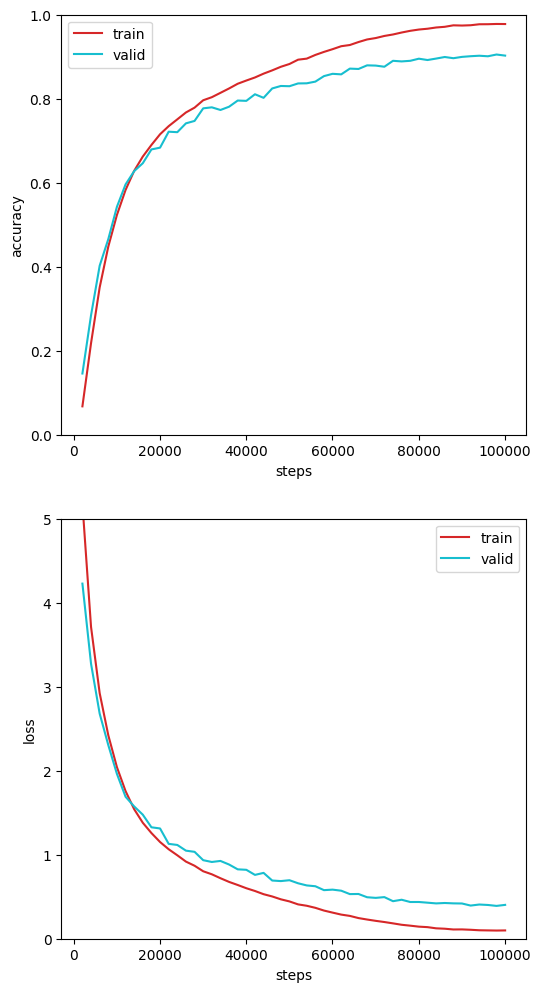

In [12]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


gap, records_train, records_valid = records.get_records_for_plot()
last_train_accu = records_train["accuracy"][-1]
last_train_loss = records_train["loss"][-1]
last_valid_accu = records_valid["accuracy"][-1]
last_valid_loss = records_valid["loss"][-1]
print(f"training accuracy: {last_train_accu:.3f} | valid accuracy: {last_valid_accu:.3f}")
print(f"training loss: {last_train_loss:.3f} | valid loss: {last_valid_loss:.3f}")

# Base figure
figure = plt.figure(figsize=(6, 12))
x = [gap * (i+1) for i in range(len(records_valid["accuracy"]))]

# accuracy
figure.add_subplot(2, 1, 1)
plt.plot(x, records_train["accuracy"], c="tab:red", label="train")
plt.plot(x, records_valid["accuracy"], c="tab:cyan", label="valid")
plt.ylim(0.0, 1.0)
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.legend()

# loss
figure.add_subplot(2, 1, 2)
plt.plot(x, records_train["loss"], c="tab:red", label="train")
plt.plot(x, records_valid["loss"], c="tab:cyan", label="valid")
plt.ylim(0.0, 5.0)
plt.xlabel("steps")
plt.ylabel("loss")
plt.legend()

plt.show()

# Inference

## Dataset of inference

In [ ]:
import os
import json
import torch
from pathlib import Path
from torch.utils.data import Dataset


class InferenceDataset(Dataset):
  def __init__(self, data_dir):
    testdata_path = Path(data_dir) / "testdata.json"
    metadata = json.load(testdata_path.open())
    self.data_dir = data_dir
    self.data = metadata["utterances"]

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    utterance = self.data[index]
    feat_path = utterance["feature_path"]
    mel = torch.load(os.path.join(self.data_dir, feat_path))

    return feat_path, mel


def inference_collate_batch(batch):
  """Collate a batch of data."""
  feat_paths, mels = zip(*batch)

  return feat_paths, torch.stack(mels)


## Main funcrion of Inference

In [ ]:
import json
import csv
from pathlib import Path
from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader

def parse_args():
  """arguments"""
  config = {
    "data_dir": "./Dataset",
    "model_path": "./model.ckpt",
    "output_path": "./output.csv",
  }

  return config


def main(
  data_dir,
  model_path,
  output_path,
):
  """Main function."""
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"[Info]: Use {device} now!")

  mapping_path = Path(data_dir) / "mapping.json"
  mapping = json.load(mapping_path.open())

  dataset = InferenceDataset(data_dir)
  dataloader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    drop_last=False,
    num_workers=8,
    collate_fn=inference_collate_batch,
  )
  print(f"[Info]: Finish loading data!",flush = True)

  speaker_num = len(mapping["id2speaker"])
  model = Classifier(n_spks=speaker_num).to(device)
  model.load_state_dict(torch.load(model_path))
  model.eval()
  print(f"[Info]: Finish creating model!",flush = True)

  results = [["Id", "Category"]]
  for feat_paths, mels in tqdm(dataloader):
    with torch.no_grad():
      mels = mels.to(device)
      outs = model(mels)
      preds = outs.argmax(1).cpu().numpy()
      for feat_path, pred in zip(feat_paths, preds):
        results.append([feat_path, mapping["id2speaker"][str(pred)]])

  with open(output_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(results)


if __name__ == "__main__":
  main(**parse_args())
